##Import libraries

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import numpy as np
import string
from nltk.tokenize import TweetTokenizer
from ast import literal_eval
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import and encode data

In [19]:
# Import data
tsd_train = pd.read_csv('gdrive/MyDrive/CSI4900-Project/data/tsd_train.csv')
tsd_test = pd.read_csv('gdrive/MyDrive/CSI4900-Project/data/tsd_test.csv')
tsd_trial = pd.read_csv('gdrive/MyDrive/CSI4900-Project/data/tsd_trial.csv')

# Convert spans from string to list
tsd_train['spans'] = tsd_train['spans'].apply(literal_eval)
tsd_test['spans'] = tsd_test['spans'].apply(literal_eval)
tsd_trial['spans'] = tsd_trial['spans'].apply(literal_eval)

In [20]:
# Lowercase all characters
tsd_train['text'] = tsd_train['text'].apply(lambda x: x.lower())
tsd_test['text'] = tsd_test['text'].apply(lambda x: x.lower())
tsd_trial['text'] = tsd_trial['text'].apply(lambda x: x.lower())
tsd_train.head(10)

,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",another violent and aggressive immigrant killi...
1,"[33, 34, 35, 36, 37, 38, 39]","i am 56 years old, i am not your fucking junio..."
2,"[0, 1, 2, 3]","damn, a whole family. sad indeed."
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",what a knucklehead. how can anyone not know th...
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\na..."
5,[],"but, but, but, is not a defense. it's not eve..."
6,"[39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 5...","please people, stop using these silly, stupid ..."
7,"[0, 1, 2, 3]",dumb.
8,"[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1...",obamacare is on it's last gasping breaths. y...
9,"[32, 33, 34, 35, 36, 37, 38, 39]",crooked trump = guilty as hell.\npathetic


In [28]:
# Find toxic words, and encoding text
def find_toxic_words(span, text):
    i = 0
    token = []
    a = 0

    word = []

    while (i < (len(span) - 1)):
        if (span[i] != (span[i+1]-1)):
            token.append(span[a:(i+1)])
            a = i + 1
        elif i == (len(span) - 2):
            token.append(span[a:i+2])

        i = i + 1

    for t in token:
        word.append(text[t[0]:(t[len(t)-1])+1])

    return word

def build_sequence(span, text):
    tknzr2 = TweetTokenizer()
    tokens = tknzr2.tokenize(text)

    for each_token in tokens:
        if each_token in string.punctuation:
            tokens.remove(each_token)

    sequence = np.zeros(len(tokens), dtype=int)
    toxic_words = find_toxic_words(span, text)

    toxic_tokens = []
    for i in range(0, len(tokens)):
        for each_toxic in toxic_words:
            t = tknzr2.tokenize(each_toxic)
            if tokens[i] in t:
                sequence[i] = 1
    
    print(tokens)
    for i in range(0, len(tokens)):
        ind = text.find(tokens[i])
        while text[ind-1] != ' ' and ind != 0:
            ind = text.find(tokens[i], ind+1, len(text))
        print(ind)

    return sequence, toxic_words

build_sequence(tsd_train['spans'][2], tsd_train['text'][2])

def encode(df):
    sequences = []
    toxic_words = []
    for index, row in df.iterrows():
        sequence, toxic_word = build_sequence(row['spans'], row['text'])
        sequences.append(sequence)
        toxic_words.append(toxic_word)
    return sequences, toxic_words

['damn', 'a', 'whole', 'family', 'sad', 'indeed']
0
6
8
14
22
26


In [5]:
sequences, toxic_words = encode(tsd_train)
tsd_train['toxic_word'] = toxic_words
tsd_train['sequence'] = sequences

sequences, toxic_words = encode(tsd_test)
tsd_test['toxic_word'] = toxic_words
tsd_test['sequence'] = sequences

sequences, toxic_words = encode(tsd_trial)
tsd_trial['toxic_word'] = toxic_words
tsd_trial['sequence'] = sequences

tsd_train.head(10)

,spans,text,toxic_word,sequence
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",another violent and aggressive immigrant killi...,[violent and aggressive immigrant],"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
1,"[33, 34, 35, 36, 37, 38, 39]","i am 56 years old, i am not your fucking junio...",[fucking],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,"[0, 1, 2, 3]","damn, a whole family. sad indeed.",[damn],"[1, 0, 0, 0, 0, 0]"
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",what a knucklehead. how can anyone not know th...,[knucklehead],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\na...",[killing],"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
5,[],"but, but, but, is not a defense. it's not eve...",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,"[39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 5...","please people, stop using these silly, stupid ...","[stupid, emoticons]","[0, 0, 0, 0, 0, 0, 1, 1]"
7,"[0, 1, 2, 3]",dumb.,[dumb],[1]
8,"[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1...",obamacare is on it's last gasping breaths. y...,"[idiots, stupid]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
9,"[32, 33, 34, 35, 36, 37, 38, 39]",crooked trump = guilty as hell.\npathetic,[pathetic],"[0, 0, 0, 0, 0, 1]"


## Word Embadding using BERT from HuggingFace

In [6]:
max_length = 128
embedding_dim = 25
max_features = 10000

# dimention of this model is 384
# bert_embedding = SentenceTransformer('all-MiniLM-L6-v2')

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tsd_train['text'].values)

X_train = tokenizer.texts_to_sequences(tsd_train['text'].values)
X_test = tokenizer.texts_to_sequences(tsd_test['text'].values)
X_trial = tokenizer.texts_to_sequences(tsd_trial['text'].values)

In [7]:
# X_train = bert_embedding.encode(tsd_train['text'])
X_train = pad_sequences(maxlen = max_length, sequences = X_train, padding = "post")
y_train = pad_sequences(maxlen = max_length, sequences = tsd_train['sequence'], padding = "post")
y_train = to_categorical(y_train, num_classes=2)

# X_test = bert_embedding.encode(tsd_test['text'])
X_test = pad_sequences(maxlen = max_length, sequences = X_test, padding = "post")
y_test = pad_sequences(maxlen = max_length, sequences = tsd_test['sequence'], padding = "post")
y_test = to_categorical(y_test, num_classes=2)

# X_trial = bert_embedding.encode(tsd_trial['text'])
X_trial = pad_sequences(maxlen = max_length, sequences = X_trial, padding = "post")
y_trial = pad_sequences(maxlen = max_length, sequences = tsd_trial['sequence'], padding = "post")
y_trial = to_categorical(y_trial, num_classes=2)

## Build LSTM Model

In [8]:
# BiLSTM
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional, Flatten, Dropout, Input
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings("ignore")

# from keras.metrics import BinaryAccuracy, Precision, Recall, AUC

input = Input(shape = (max_length,))
model = Embedding(input_dim=385,
                    output_dim=embedding_dim,
                    input_length=max_length,
                    trainable=True)(input)

model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units = max_length, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(max_length, activation="relu"))(model)

out = Dense(2, activation="sigmoid", kernel_initializer='glorot_uniform')(model)  # output

model = Model(input, out)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 25)           9625      
                                                                 
 dropout (Dropout)           (None, 128, 25)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 128, 256)         157696    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 128, 128)         32896     
 ibuted)                                                         
                                                                 
 dense_1 (Dense)             (None, 128, 2)            258   

In [9]:
model.fit(X_train, np.array(y_train), batch_size=64, epochs=10, validation_data=(X_trial, y_trial))

# Save model
model.save('gdrive/MyDrive/CSI4900-Project/LSTM/my_model.h5')

Epoch 1/10
125/125 [==============================] - 164s 1s/step - loss: 0.1418 - accuracy: 0.9696 - val_loss: 0.0781 - val_accuracy: 0.9783
Epoch 2/10
125/125 [==============================] - 156s 1s/step - loss: 0.0855 - accuracy: 0.9748 - val_loss: 0.0805 - val_accuracy: 0.9783
Epoch 3/10
125/125 [==============================] - 156s 1s/step - loss: 0.0821 - accuracy: 0.9751 - val_loss: 0.0732 - val_accuracy: 0.9787
Epoch 4/10
125/125 [==============================] - 155s 1s/step - loss: 0.0799 - accuracy: 0.9758 - val_loss: 0.0717 - val_accuracy: 0.9789
Epoch 5/10
125/125 [==============================] - 153s 1s/step - loss: 0.0797 - accuracy: 0.9759 - val_loss: 0.0731 - val_accuracy: 0.9787
Epoch 6/10
125/125 [==============================] - 152s 1s/step - loss: 0.0787 - accuracy: 0.9762 - val_loss: 0.0718 - val_accuracy: 0.9793
Epoch 7/10
125/125 [==============================] - 150s 1s/step - loss: 0.0780 - accuracy: 0.9763 - val_loss: 0.0709 - val_accuracy: 0.9794

## Evaluation

In [10]:
# Read saved model
from tensorflow.keras.models import load_model
saved_model = load_model('gdrive/MyDrive/CSI4900-Project/LSTM/my_model.h5')

In [11]:
# Define evaluation functions

import sys
from scipy.stats import sem
import numpy as np
from ast import literal_eval

def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1. if len(predictions) == 0 else 0.
    if len(predictions) == 0:
        return 0.
    predictions_set = set(predictions)
    gold_set = set(gold)
    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)
    return float(nom)/float(denom)


def evaluate(pred, gold):
    """
    Based on https://github.com/felipebravom/EmoInt/blob/master/codalab/scoring_program/evaluation.py
    :param pred: file with predictions
    :param gold: file with ground truth
    :return:
    """
    # read the predictions
    pred_lines = pred.readlines()
    # read the ground truth
    gold_lines = gold.readlines()

    # only when the same number of lines exists
    if (len(pred_lines) == len(gold_lines)):
        data_dic = {}
        for n, line in enumerate(gold_lines):
            parts = line.split('\t')
            if len(parts) == 2:
                data_dic[int(parts[0])] = [literal_eval(parts[1])]
            else:
                raise ValueError('Format problem for gold line %d.', n)

        for n, line in enumerate(pred_lines):
            parts = line.split('\t')
            if len(parts) == 2:
                if int(parts[0]) in data_dic:
                    try:
                        data_dic[int(parts[0])].append(literal_eval(parts[1]))
                    except ValueError:
                        # Invalid predictions are replaced by a default value
                        data_dic[int(parts[0])].append([])
                else:
                    raise ValueError('Invalid text id for pred line %d.', n)
            else:
                raise ValueError('Format problem for pred line %d.', n)

        # lists storing gold and prediction scores
        scores = []
        for id in data_dic:
            if len(data_dic[id]) == 2:
                gold_spans = data_dic[id][0]
                pred_spans = data_dic[id][1]
                scores.append(f1(pred_spans, gold_spans))
            else:
                sys.exit('Repeated id in test data.')

        return (np.mean(scores), sem(scores))

    else:
        sys.exit('Predictions and gold data have different number of lines.')

In [12]:
y_predicted = model.predict(X_test)
y_predicted = np.argmax(y_predicted, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [13]:
#tsd_test["f1_scores"] = tsd_test.apply(lambda row: f1(row.spans_predicted, row.spans), axis=1)

f1_scores = []
for i in range(0, len(y_test_true)):
    score = f1(y_predicted[i], y_test_true[i])
    f1_scores.append(score)
tsd_test['f1_scores'] = f1_scores

tsd_test.head(10)

,spans,text,toxic_word,sequence,f1_scores
0,"[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...",that's right. they are not normal. and i am st...,"[abnormal, sexist rubbish]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.666667
1,"[81, 82, 83, 84, 85, 86]","""watch people die from taking away their healt...",[stupid],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.666667
2,[],tens years ago i contacted the pdr and suggest...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
3,[],the parallels between the anc and the sicilian...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
4,[],intel community: ‘how can we work for a presid...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
5,"[129, 130, 131, 132, 133, 134]",i live in an area that saw major flood damage ...,[stupid],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.666667
6,"[35, 36, 37, 38, 39, 40, 41, 42, 43]",elaine marie jeffers sounds like a sociopath 😕.,[sociopath],"[0, 0, 0, 0, 0, 0, 1, 0]",0.666667
7,"[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116...",a rock has more mental horsepower than the ind...,"[ignorant, dishonest people]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1.000000
8,"[37, 38, 39, 40, 41, 158, 159, 160, 161, 204, ...","ha ha, hillary lost. all you hillary fools nee...","[fools, dump, trash]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
9,"[94, 95, 96, 97]",yes....it is to be expected....oddly enough it...,[dumb],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.666667


F1 = 0.84 ± 0.00


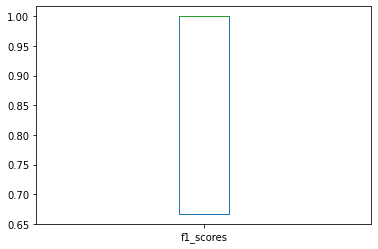

In [14]:
from scipy.stats import sem
_ = tsd_test.f1_scores.plot(kind="box")
print (f"F1 = {tsd_test.f1_scores.mean():.2f} ± {sem(tsd_test.f1_scores):.2f}")

In [15]:
# make sure that the ids match the ones of the scores
predictions = y_predicted.tolist()
ids = tsd_test.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("gdrive/MyDrive/CSI4900-Project/LSTM/spans-pred.txt", "w") as out:
  for uid, text_scores in zip(ids, predictions):
    out.write(f"{str(uid)}\t{str(text_scores)}\n")

! head gdrive/MyDrive/CSI4900-Project/LSTM/spans-pred.txt

0	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [16]:
gold = y_test_true.tolist()
ids = tsd_test.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("gdrive/MyDrive/CSI4900-Project/LSTM/spans-gold.txt", "w") as out:
  for uid, text_scores in zip(ids, gold):
    out.write(f"{str(uid)}\t{str(text_scores)}\n")

! head gdrive/MyDrive/CSI4900-Project/LSTM/spans-gold.txt

0	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [17]:
predictions = open("gdrive/MyDrive/CSI4900-Project/LSTM/spans-pred.txt", "r")
gold = open("gdrive/MyDrive/CSI4900-Project/LSTM/spans-gold.txt", "r")

score = evaluate(predictions, gold)
print(score)

(0.8361666666666665, 0.003727173313713119)
